# Automatic Differentiation

In [1]:
from math import ceil
from time import perf_counter
import functools

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm, trange
from graphviz import Digraph
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_theme()

## Implement `Variable` (computational graph + backprop)

A `Variable` is a node within a neural network. It has parents which together with other nodes forms a directed acylic graph (DAG). It also has a `grad` field to store its gradient calculated using the back propagation algorithm. We implement `Variable` by subclassing `np.ndarray` and intercepting numpy operators to inject our own logic.

In [2]:
def to_np(tensors):
    return tuple(x.view(np.ndarray) if isinstance(x, Variable) else x for x in tensors)

def build_graph(op, args, arr):
    if arr is NotImplemented:
        return NotImplemented
    if not isinstance(arr, np.ndarray):
        arr = np.array(arr)
    arr = arr.view(Variable)
    if Variable.requires_grad:
        arr.op = op
        arr.parents = args
    return arr

class Variable(np.ndarray):
    next_id = 0
    debug = False
    requires_grad = True
    
    def __array_finalize__(self, obj):
        if self.debug: print(f'__array_finalize__ {self.shape} {obj.shape}')
        if obj is None: return
        self.op = getattr(obj, 'op', None)
        self.parents = getattr(obj, 'parents', None)
        self.name = getattr(obj, 'name', None)
        self.grad = np.zeros(obj.shape)
        Variable.next_id, self.id = Variable.next_id + 1, Variable.next_id

    def __array_ufunc__(self, ufunc, method, *args, **kwargs):
        np_args = to_np(args)
        if 'out' in kwargs:
            kwargs['out'] = to_np(kwargs['out'])
        if self.debug: print(f'__array_ufunc__ {ufunc} {[x.shape for x in np_args]} {kwargs}')
        arr = super().__array_ufunc__(ufunc, method, *np_args, **kwargs)
        return build_graph(ufunc, args, arr)

    def __array_function__(self, func, types, args, kwargs):
        np_args = to_np(args)
        if self.debug: print(f'__array_function__ {func} {[x.shape for x in np_args]}')
        arr = func(*np_args, **kwargs)
        return build_graph(func, args, arr)

    def backward(self, grad=None):
        """Back propagation"""
        if grad is None:
            # Is root (ie loss node)
            grad = np.ones(self.shape)
        
        if len(grad.shape) == len(self.grad.shape) + 1 and grad.shape[1:] == self.grad.shape:
            # Average gradient in minibatch
            grad = np.mean(grad, axis=0)
        # Accumulate gradient
        # (instead of simply setting it to deal with nodes with multiple children)
        self.grad += grad

        for i, parent in enumerate(self.parents or []):
            if isinstance(parent, Variable):
                backprop_grad = backprop[self.op](self.parents, i, grad)
                parent.backward(backprop_grad)

    def graph(self, g=None):
        """Graphviz support"""
        if g is None:
            g = Digraph()
        g.node(str(self.id), label=self.label(), xlabel=self.op.__name__ if self.op else None)
        for parent in self.parents or []:
            if not isinstance(parent, Variable):
                id, Variable.next_id = str(Variable.next_id), Variable.next_id + 1
                g.node(id, label=str(parent))
                g.edge(id, str(self.id))
            else:
                g.edge(str(parent.id), str(self.id))
                parent.graph(g)
        return g

    def __hash__(self):
        return self.id

    def __eq__(self, other):
        return self.id == other.id

    def __repr__(self):
        return f'{self.label()}({str(self)}, grad={self.grad})'

    def label(self):
        return self.name or f'v{self.id}'

class no_grad:
    def __init__(self):
        self.prev = None
    def __enter__(self):
        self.prev = Variable.requires_grad
        Variable.requires_grad = False
    def __exit__(self, *args):
        Variable.requires_grad = self.prev

def var(x: np.ndarray, name: tuple[str, str]):
    v = x.view(Variable)
    v.name = '.'.join(name)
    return v

def custom_op(func):
    """Bypass numpy hooks so we can implement our own backprop logic"""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        if all(isinstance(arg, Variable) for arg in args):
            np_args = to_np(args)
            arr = func(*np_args, **kwargs)
            return build_graph(wrapper, args, arr)
        else:
            return func(*args, **kwargs)
    return wrapper

In [3]:
def relu(x):
    return np.maximum(x, 0)

def softmax(x):
    # Stable implementation
    z = x - np.max(x, axis=-1)[:, np.newaxis]
    numerator = np.exp(z)
    return numerator / np.sum(numerator, axis=-1)[:, np.newaxis]

@custom_op
def log_softmax(x):
    # Stable implementation
    shiftx = x - np.max(x, axis=-1)[:, np.newaxis]
    return shiftx - np.log(np.sum(np.exp(shiftx), axis=-1))[:, np.newaxis]

def mse_loss(y_pred, y):
    return np.mean(np.square(y - y_pred))

@custom_op
def nll_loss(y_pred, y):
    """y_pred is one-hot encoded (batch, logits), y is class labels (batch,)"""
    return -np.mean(y_pred[range(y.shape[0]), y])

## Implement backprop for all supported operations

Concrete implementations for equation [6.54](https://www.deeplearningbook.org/contents/mlp.html#pf31):

$$ \text{op.bprop}(\text{inputs}, \textsf{X}, \textsf{G}) = \sum_i (\nabla_\textsf{X}\text{op.f}(\text{inputs})_i) ~\textsf{G}_i $$

In [4]:
backprop = {}
def bprop(forward_fn):
    def decorator(backward_fn):
        @functools.wraps(backward_fn)
        def wrapper(inputs, idx, G):
            return backward_fn(to_np(inputs), idx, G)
        backprop[forward_fn] = wrapper
        return wrapper
    return decorator

@bprop(np.add)
def bprop_add(inputs, idx, G):
    return G

@bprop(np.subtract)
def bprop_subtract(inputs, idx, G):
    A, B = inputs
    return G if idx == 0 else -G

@bprop(np.square)
def bprop_square(inputs, idx, G):
    return 2. * inputs[0] * G

@bprop(np.mean)
def bprop_mean(inputs, idx, G):
    return G / inputs[0].shape[0]

@bprop(np.matmul)
def bprop_matmul(inputs, idx, G):
    A, B = inputs
    match idx:
        case 0: return G @ np.moveaxis(B, -1, -2)
        case 1: return A.T @ G

@bprop(np.maximum)
def bprop_maximum(inputs, idx, G):
    A, B = inputs
    mask = A > B if idx == 0 else B > A
    return mask.astype(np.float64) * G

@bprop(np.squeeze)
def bprop_squeeze(inputs, idx, G):
    return np.expand_dims(G, -1)

@bprop(np.expand_dims)
def bprop_expand_dims(inputs, idx, G):
    return np.squeeze(G, -1)

@bprop(log_softmax)
def bprop_log_softmax(inputs, idx, G):
    return G - softmax(inputs[0]) * G.sum(axis=1, keepdims=True)

@bprop(nll_loss)
def bprop_nll_loss(inputs, idx, G):
    y_pred, y = inputs
    if idx == 0:
        G /= y_pred.shape[0]
        return (softmax(y_pred) - np.eye(y_pred.shape[1])[y]) * G

## Implement basic neural network primitives

In [5]:
class Module:
    def parameters(self):
        out = []
        for attr in self.__dict__.values():
            if isinstance(attr, Variable):
                out.append(attr)
            elif isinstance(attr, Module):
                out.extend(attr.parameters())
        return out

class Linear(Module):
    def __init__(self, in_dim: int, out_dim: int, name: str = 'fc'):
        self.W = var(np.random.randn(out_dim, in_dim), name=(name, 'W'))
        self.b = var(np.random.randn(out_dim), name=(name, 'b'))

    def __call__(self, x):
        return np.squeeze(self.W @ np.expand_dims(x, axis=-1), axis=-1) + self.b

class AdamW:
    """https://arxiv.org/pdf/1711.05101"""
    def __init__(self,
                 params,
                 lr=0.001,
                 betas=(0.9, 0.999),
                 eps=1e-8,
                 weight_decay=0.01):
        self.params = params
        self.lr = lr
        self.b1, self.b2 = betas
        self.eps = eps
        self.weight_decay = weight_decay
        self.m = [np.zeros(param.shape) for param in params]
        self.v = [np.zeros(param.shape) for param in params]
        self.t = 1

    def step(self):
        with no_grad():
            for i, var in enumerate(self.params):
                self.m[i] = self.b1 * self.m[i] + (1 - self.b1) * var.grad
                self.v[i] = self.b2 * self.v[i] + (1 - self.b2) * np.square(var.grad)
                m_hat = self.m[i] / (1 - self.b1 ** self.t)
                v_hat = self.v[i] / (1 - self.b2 ** self.t)
                var -= (self.lr * m_hat) / (np.sqrt(v_hat) + self.eps)
                var *= 1 - self.lr * self.weight_decay
        self.t += 1

    def zero_grad(self):
        for var in self.params:
            var.grad[...] = 0.

def train(
    model,
    X_train,
    y_train,
    loss_fn,
    metrics_fn,
    optim,
    X_val=None,
    y_val=None,
    batch_size=64,
    max_epochs=100,
    log_epochs=1,
    log_iters=1,
    early_stopping_delta=1e-6,
    early_stopping_patience=4,
):
    n_split = ceil(X_train.shape[0] / batch_size)
    X_batches, y_batches = np.array_split(X_train, n_split), np.array_split(y_train, n_split)
    x_batches = [var(x, name='x') for x in X_batches]
    y_batches = [var(y, name='y') for y in y_batches]
    losses = []
    val_losses = []
    min_loss = float('inf')
    start = perf_counter()
    for i in (epoch_pbar := trange(max_epochs, desc='Epoch')):
        running_loss = 0.
        running_acc = 0.
        with tqdm(desc='Iter', total=len(x_batches), leave=False, disable=len(x_batches) == 1) as iter_pbar:
            for j, (X_batch, y_batch) in enumerate(zip(x_batches, y_batches)):
                optim.zero_grad()
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                running_loss += loss.item()
                acc = metrics_fn(y_pred, y_batch)
                running_acc += acc.item()
                if j % log_iters == 0:
                    iter_pbar.set_postfix(loss=loss.item(), acc=acc.item())
                loss.backward()
                optim.step()
                iter_pbar.update(1)
        loss = running_loss / len(x_batches)
        losses.append(loss)
        min_loss = min(min_loss, loss)
        acc = running_acc / len(x_batches)
        val_loss = val_acc = None
        if X_val is not None:
            with no_grad():
                y_pred = model(X_val)
                val_loss = loss_fn(y_pred, y_val).item()
                val_losses.append(val_loss)
                val_acc = metrics_fn(y_pred, y_val).item()
        if i % log_epochs == 0:
            elapsed = perf_counter() - start
            epoch_pbar.set_postfix(loss=loss, acc=acc, val_loss=val_loss, val_acc=val_acc, elapsed=elapsed)
        if len(losses) >= early_stopping_patience:
            if all(abs(x - min_loss) < early_stopping_delta for x in losses[-early_stopping_patience:]):
                break
    elapsed = perf_counter() - start
    print(f'Total epochs = {i + 1} | elapsed = {elapsed:.2f}s | train loss = {loss} | train acc = {acc}')
    return sns.lineplot(pd.DataFrame({
        'train': losses,
        'val': val_losses or None
    })).set(xlabel='Epochs', ylabel='Loss')

## Demo 1: XOR

In [6]:
class Xor(Module):
    def __init__(self, in_dim: int, hidden_dim: int, out_dim: int):
        self.fc1 = Linear(in_dim, hidden_dim, name='fc1')
        self.fc2 = Linear(hidden_dim, out_dim, name='fc2')

    def __call__(self, x):
        x = self.fc1(x)
        x = relu(x)
        x = self.fc2(x)
        return x

xor_X = np.array([[0., 0.], [1., 0.], [0., 1.], [1., 1.]])
xor_y = np.array([[0.], [1.], [1.], [0.]])

np.random.seed(0)

xor_model = Xor(2, 2, 1)
xor_optim = AdamW(xor_model.parameters(), lr=0.05)
xor_acc = lambda y_pred, y: np.mean((y_pred.view(np.ndarray) >= 0.5) == y.view(np.ndarray))

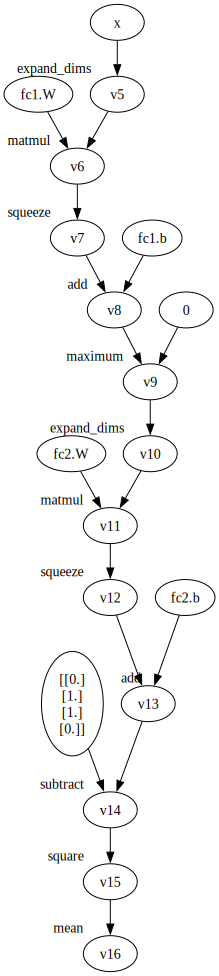

In [7]:
xor_y_pred = xor_model(var(xor_X, 'x'))
xor_loss = mse_loss(xor_y_pred, xor_y)
xor_loss.graph()

Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Total epochs = 1261 | elapsed = 0.26s | train loss = 3.668129230050844e-05 | train acc = 1.0
array([[0.0085538 ],
       [0.99419049],
       [0.99486754],
       [0.00459919]])


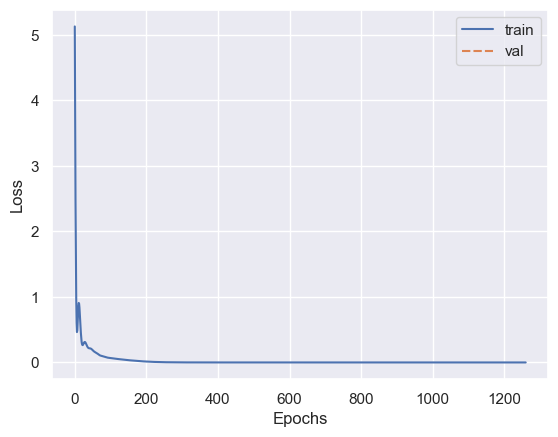

In [8]:
train(xor_model, xor_X, xor_y, mse_loss, xor_acc, xor_optim,
      max_epochs=10000,
      log_epochs=100,
      early_stopping_patience=10)
with no_grad():
    print(np.array_repr(xor_model(var(xor_X, name='x')), suppress_small=True))

## Demo 2: MNIST

In [9]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

mnist = datasets.fetch_openml(name='mnist_784')

In [10]:
mnist_X = mnist.data.to_numpy().astype(np.float64)
mnist_X = mnist_X * (2 / 255) - 1. # Normalize to [-1, 1]
mnist_y = mnist.target.to_numpy().astype(np.int64)

mnist_X_train, mnist_X_test, mnist_y_train, mnist_y_test = train_test_split(
    mnist_X, mnist_y, train_size=10000, test_size=5000)
mnist_X_train.shape, mnist_X_test.shape, mnist_y_train.shape, mnist_y_test.shape

((10000, 784), (5000, 784), (10000,), (5000,))

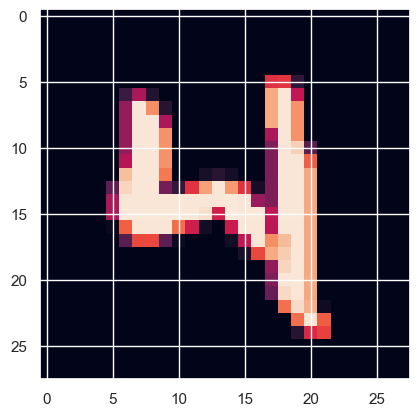

4


In [11]:
plt.imshow(mnist_X_train[0].reshape(28, 28))
plt.show()
print(mnist_y_train[0])

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iter:   0%|          | 0/100 [00:00<?, ?it/s]

Iter:   0%|          | 0/100 [00:00<?, ?it/s]

Iter:   0%|          | 0/100 [00:00<?, ?it/s]

Iter:   0%|          | 0/100 [00:00<?, ?it/s]

Iter:   0%|          | 0/100 [00:00<?, ?it/s]

Iter:   0%|          | 0/100 [00:00<?, ?it/s]

Iter:   0%|          | 0/100 [00:00<?, ?it/s]

Iter:   0%|          | 0/100 [00:00<?, ?it/s]

Iter:   0%|          | 0/100 [00:00<?, ?it/s]

Iter:   0%|          | 0/100 [00:00<?, ?it/s]

Iter:   0%|          | 0/100 [00:00<?, ?it/s]

Iter:   0%|          | 0/100 [00:00<?, ?it/s]

Iter:   0%|          | 0/100 [00:00<?, ?it/s]

Iter:   0%|          | 0/100 [00:00<?, ?it/s]

Iter:   0%|          | 0/100 [00:00<?, ?it/s]

Iter:   0%|          | 0/100 [00:00<?, ?it/s]

Iter:   0%|          | 0/100 [00:00<?, ?it/s]

Iter:   0%|          | 0/100 [00:00<?, ?it/s]

Iter:   0%|          | 0/100 [00:00<?, ?it/s]

Iter:   0%|          | 0/100 [00:00<?, ?it/s]

Total epochs = 20 | elapsed = 301.99s | train loss = 1.5187869587915024 | train acc = 0.9773999999999994


[Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'Loss')]

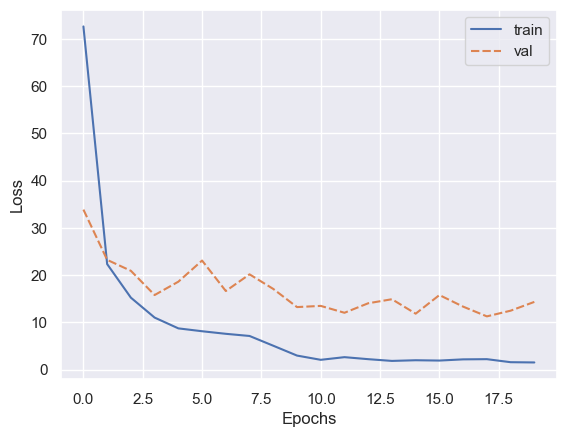

In [12]:
class MNISTModel(Module):
    def __init__(self):
        self.fc1 = Linear(784, 800, name='fc1')
        self.fc2 = Linear(800, 10, name='fc2')

    def __call__(self, x):
        x = self.fc1(x)
        x = relu(x)
        x = self.fc2(x)
        return log_softmax(x)
        
np.random.seed(0)

mnist_model = MNISTModel()
mnist_optim = AdamW(mnist_model.parameters(), lr=0.005)
mnist_acc = lambda y_pred, y: np.mean(np.argmax(y_pred.view(np.ndarray), axis=1) == y.view(np.ndarray))
train(mnist_model, mnist_X_train, mnist_y_train, nll_loss, mnist_acc, mnist_optim,
      X_val=mnist_X_test,
      y_val=mnist_y_test,
      batch_size=100,
      max_epochs=20,
      log_iters=10,
      early_stopping_delta=1e-3,
      early_stopping_patience=3)

### Test MNIST model

In [13]:
with no_grad():
    mnist_y_test_pred = mnist_model(mnist_X_test)
    mnist_acc = mnist_acc(mnist_y_test_pred, mnist_y_test)
print(mnist_acc)

0.9068
